# 1. Settings

## 1.1 User variables

In [1]:
from config import *

NB_RUNS = 30

TARGETS = [TARGET]
HEURISTICS = ["try_all_atoms", "max_coverage_static"] #["max_coverage_static"] #["try_all_atoms", "max_coverage_dynamic", "max_coverage_static", "max_diversity"]
THREADS = 8
USE_NAN = True

DATA_PATH = "tmp/data_discrete.csv"

# 1.2 Dev variables

In [2]:
RANDOM_SEED = 0

INPUT_DATA_DISCRETE = "tmp/data_discrete.csv"
OUTPUT_CSV = "tmp/lfit_output.csv"

VERBOSE = True

## 1.3 Imports

In [3]:
import pandas as pd
import numpy
import random
import pylfit
import os

random.seed(RANDOM_SEED)
numpy.random.seed(RANDOM_SEED)

## 1.4 Constants

In [4]:
# Constants
DEBUG = False

# 2. Data Loading

# DEBUG

In [5]:
# DEBUG
print("Training dataset:")
df = pd.read_csv(DATA_PATH)
cols = [c for c in df.columns if c not in TARGETS]

display(df)

for target in TARGETS:
    for val in df[target].unique():
        print(val,len(df[df[target] == val]))

Training dataset:


,M15,Juniperus,Larix,Picea,Pinus,Alnus,Betula,Fraxinus,Populus,Quercus,...,Ambrosia,Artemesia,Asteraceae,Chenopodiaceae,Cyperaceae,Myrica,Poaceae,Typha,Aquatics,Poaceae_prev
0,-1,-1,1,1,-1,1,-1,1,-1,1,...,-1,1,1,1,-1,1,1,1,0,0
1,1,-1,-1,-1,1,1,1,-1,1,-1,...,1,-1,1,-1,1,-1,-1,-1,0,0
2,-1,1,-1,1,1,-1,-1,1,1,-1,...,1,-1,1,-1,1,-1,-1,1,0,0
3,-1,1,1,-1,-1,1,1,-1,0,1,...,-1,1,0,1,1,1,-1,0,0,0
4,1,0,1,1,-1,-1,-1,1,-1,1,...,-1,-1,-1,-1,-1,-1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,1,-1,-1,-1,1,0,-1,-1,-1,-1,...,-1,-1,1,1,1,1,-1,-1,0,0
57,-1,-1,1,1,-1,1,1,1,1,1,...,1,1,0,-1,1,-1,-1,1,-1,1
58,1,-1,1,1,-1,-1,1,0,1,-1,...,-1,-1,0,-1,-1,1,1,1,1,1
59,-1,1,-1,-1,1,1,1,-1,-1,-1,...,1,1,0,1,-1,1,1,-1,-1,1


1 30
-1 31


In [6]:
# Load training dataset
cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
df[cols] = df[cols].astype('Int64')
df[cols] = df[cols].astype('string')

if not USE_NAN:
    df = df.dropna()
else:
    df = df.fillna("?")

col_order = list(df.columns)

df_output = pd.DataFrame(columns=["head_variable", "head_value", "body", "rule_size"])

for run_id in range(NB_RUNS):
    # Shuffle variables
    random.shuffle(col_order)
    df = df[col_order]

    FEATURES = [c for c in df.columns if c not in TARGETS]

    df.to_csv("tmp/lfit_input.csv")

    # Convert array data as a DiscreteStateTransitionsDataset using pylfit.preprocessing
    dataset = pylfit.preprocessing.discrete_state_transitions_dataset_from_csv(path="tmp/lfit_input.csv", \
    feature_names=FEATURES, target_names=TARGETS,unknown_values=["?"])

    # Initialize a DMVLP with the dataset variables and set GULA as learning algorithm
    model = pylfit.models.DMVLP(features=dataset.features, targets=dataset.targets)
    model.compile(algorithm="pride") # model.compile(algorithm="pride")
    model.fit(dataset=dataset, options={"heuristics":HEURISTICS, "verbose":0, "threads":THREADS})

    # Save rules
    rules_data = []

    for r in model.rules:
        body = ""
        for i in sorted(list(r.body.items())):
            body += i[1].to_string() + ", "
        if (len(body)>0):
            body = body[:-2]
        rules_data.append([r.head.variable, r.head.value, body, r.size(),r]) #, r.to_string()])

    df_rules = pd.DataFrame(rules_data, columns=["head_variable", "head_value", "body", "rule_size","raw_rule"]) #, "rule_raw_form"])

    nb_rules_of_run = len(df_rules)
    nb_rules_total_before = len(df_output)

    df_output = pd.concat([df_output,df_rules]).reset_index(drop=True)
    df_output.drop_duplicates(subset=["head_variable", "head_value", "body", "rule_size"], inplace=True)

    nb_new_rules = len(df_output) - nb_rules_total_before
    nb_duplicate_rules = nb_rules_of_run - nb_new_rules
    
    print("Run",str(run_id+1)+"/"+str(NB_RUNS),"- new rules found:", nb_new_rules, "- total:",len(df_output),"- duplicate:",nb_duplicate_rules)

    df_output.to_csv(OUTPUT_CSV,index=False)

display(df_output)


Run 1/30 - new rules found: 193 - total: 193 - duplicate: 0
Run 2/30 - new rules found: 138 - total: 331 - duplicate: 60
Run 3/30 - new rules found: 78 - total: 409 - duplicate: 102
Run 4/30 - new rules found: 78 - total: 487 - duplicate: 127
Run 5/30 - new rules found: 57 - total: 544 - duplicate: 115
Run 6/30 - new rules found: 35 - total: 579 - duplicate: 161
Run 7/30 - new rules found: 21 - total: 600 - duplicate: 122
Run 8/30 - new rules found: 83 - total: 683 - duplicate: 134
Run 9/30 - new rules found: 23 - total: 706 - duplicate: 153
Run 10/30 - new rules found: 44 - total: 750 - duplicate: 118
Run 11/30 - new rules found: 21 - total: 771 - duplicate: 136
Run 12/30 - new rules found: 10 - total: 781 - duplicate: 164
Run 13/30 - new rules found: 2 - total: 783 - duplicate: 132
Run 14/30 - new rules found: 18 - total: 801 - duplicate: 194
Run 15/30 - new rules found: 20 - total: 821 - duplicate: 136
Run 16/30 - new rules found: 22 - total: 843 - duplicate: 146
Run 17/30 - new rul

,head_variable,head_value,body,rule_size,raw_rule
0,Poaceae,-1,"Betula(1), Myrica(1), Salix(1)",3,"Poaceae(-1) :- Betula(1), Myrica(1), Salix(1)."
1,Poaceae,-1,"Betula(1), Larix(1), Populus(0)",3,"Poaceae(-1) :- Betula(1), Larix(1), Populus(0)."
2,Poaceae,-1,"Alnus(1), Larix(1), Salix(1)",3,"Poaceae(-1) :- Alnus(1), Larix(1), Salix(1)."
3,Poaceae,-1,"Asteraceae(0), Cyperaceae(1)",2,"Poaceae(-1) :- Asteraceae(0), Cyperaceae(1)."
4,Poaceae,-1,"Chenopodiaceae(1), Cyperaceae(1), Larix(1), My...",4,"Poaceae(-1) :- Chenopodiaceae(1), Cyperaceae(1..."
...,...,...,...,...,...
1058,Poaceae,1,"Artemesia(-1), Pinus(1), Quercus(1), Ulmus(1)",4,"Poaceae(1) :- Artemesia(-1), Pinus(1), Quercus..."
1061,Poaceae,1,"Artemesia(-1), Typha(-1), Ulmus(1)",3,"Poaceae(1) :- Artemesia(-1), Typha(-1), Ulmus(1)."
1062,Poaceae,1,"Artemesia(-1), Fraxinus(1), Quercus(1), Ulmus(1)",4,"Poaceae(1) :- Artemesia(-1), Fraxinus(1), Quer..."
1063,Poaceae,1,"Artemesia(-1), Picea(1), Poaceae_prev(1), Ulmu...",4,"Poaceae(1) :- Artemesia(-1), Picea(1), Poaceae..."


# Evaluation

In [7]:
def score_rule(rule,df):
    true_pos = 0
    false_pos = 0
    unknown_true_pos = 0
    unknown_false_pos = 0

    for idx, row in df.iterrows():
        matches = "FULL"
        for (var,val) in rule.body.items():
            if (str(row[var]) != "?"):
                if (str(row[var]) != str(val.value)):
                    matches = "NO"
                    break
            else:
                matches = "PARTIAL"

        if matches == "FULL":
            if str(row[rule.head.variable]) == str(rule.head.value):
                true_pos += 1
            else:
                false_pos += 1
        elif matches == "PARTIAL":
            if str(row[rule.head.variable]) == str(rule.head.value):
                unknown_true_pos += 1
            else:
                unknown_false_pos += 1

    if (true_pos + false_pos) == 0:
        accuracy = 0
    else:
        accuracy = true_pos / (true_pos + false_pos)

    if (true_pos + unknown_false_pos) == 0:
        unknown_accuracy = 0
    else:
        unknown_accuracy = true_pos / (true_pos + unknown_false_pos)

    return true_pos, false_pos, accuracy, unknown_true_pos, unknown_false_pos, unknown_accuracy

In [8]:
TRAINING_DATASET = INPUT_DATA_DISCRETE
TEST_DATASET = None

for dataset, state  in [(TRAINING_DATASET, "train"), (TEST_DATASET, "test")]:
    if dataset is None:
        break
    #print("Evaluation of rules on",state,":",dataset)
    true_pos = []
    false_pos = []
    accuracy = []
    unknown_true_pos = []
    unknown_false_pos = []
    unknown_accuracy = []

    df = pd.read_csv(dataset)
    cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
    df[cols] = df[cols].astype('Int64')
    df[cols] = df[cols].astype('string')
    if not USE_NAN:
        df = df.dropna()
    else:
        df = df.fillna("?")

    for idx, row in df_output.iterrows():
        tp, fp, acc, utp, ufp, uacc = score_rule(row["raw_rule"], df)
        true_pos += [tp]
        false_pos += [fp]
        accuracy += [acc]
        unknown_true_pos += [utp]
        unknown_false_pos += [ufp]
        unknown_accuracy += [uacc]
        print("\r",str(idx+1)+"/"+str(len(df_output)),end="")

    df_output["true_positives"] = true_pos
    df_output["false_positives"] = false_pos
    df_output["accuracy"] = accuracy
    #df_output["unknown_true_positives"] = unknown_true_pos
    #df_output["unknown_false_positives"] = unknown_false_pos
    #df_output["unknown_accuracy"] = unknown_accuracy
    print()


df_output = df_output.sort_values(["accuracy","true_positives"],ascending=False)
df_output.drop(["raw_rule"], axis=1,inplace=True)

df_output = df_output.drop_duplicates()
df_output.to_csv(OUTPUT_CSV,index=False)

display(df_output)

 1105/952


,head_variable,head_value,body,rule_size,true_positives,false_positives,accuracy
28,Poaceae,-1,"Ambrosia(1), Poaceae_prev(0)",2,10,0,1.0
11,Poaceae,-1,"Betula(1), Poaceae_prev(0)",2,9,0,1.0
34,Poaceae,-1,"Alnus(-1), Ambrosia(1), Picea(1)",3,9,0,1.0
55,Poaceae,-1,"Asteraceae(1), M15(1), Quercus(-1)",3,8,0,1.0
191,Poaceae,1,"Ambrosia(-1), Picea(1), Ulmus(1)",3,8,0,1.0
...,...,...,...,...,...,...,...
936,Poaceae,1,"Fraxinus(0), Juniperus(0), Populus(1), Quercus...",4,1,0,1.0
937,Poaceae,1,"Juniperus(0), Picea(-1), Populus(1), Quercus(-1)",4,1,0,1.0
938,Poaceae,1,"Alnus(1), Betula(-1), Juniperus(0), Quercus(-1)",4,1,0,1.0
939,Poaceae,1,"Chenopodiaceae(1), Quercus(-1), Salix(0)",3,1,0,1.0


In [12]:
TOP_K_RULES = 10
MIN_SUPPORT = 1

VEN_TOP_K_RULES = 200

TARGETS = ["O15"]

import pandas as pd
import numpy
from upsetplot import UpSet
import matplotlib.pyplot as plt

LEVELS = df_output["head_value"].nunique()
LEVELS

2

In [13]:
def decode(body,include_value=True):
    conditions = []
    body = body.split(", ")

    for token in body:
        condition = token.split("(")[0].strip()
        val = token.split("(")[1].split(")")[0].strip()
        #if condition in metabolite_mapping:
        #    condition = metabolite_mapping[condition]
        if include_value:
            condition += "("+val+")"
        conditions += [condition]
    return conditions

-1


C:\Users\Tony\AppData\Local\Temp\ipykernel_6488\751918124.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["confidence"] = df["true_positives"] * df["accuracy"]


,head_variable,head_value,body,rule_size,true_positives,false_positives,accuracy,features,confidence
28,Poaceae,-1,"Ambrosia(1), Poaceae_prev(0)",2,10,0,1.0,"[Ambrosia(1), Poaceae_prev(0)]",10.0
34,Poaceae,-1,"Alnus(-1), Ambrosia(1), Picea(1)",3,9,0,1.0,"[Alnus(-1), Ambrosia(1), Picea(1)]",9.0
11,Poaceae,-1,"Betula(1), Poaceae_prev(0)",2,9,0,1.0,"[Betula(1), Poaceae_prev(0)]",9.0
55,Poaceae,-1,"Asteraceae(1), M15(1), Quercus(-1)",3,8,0,1.0,"[Asteraceae(1), M15(1), Quercus(-1)]",8.0
337,Poaceae,-1,"Ambrosia(1), Larix(1), Picea(1)",3,8,0,1.0,"[Ambrosia(1), Larix(1), Picea(1)]",8.0
237,Poaceae,-1,"Alnus(-1), Ambrosia(1), Larix(1)",3,8,0,1.0,"[Alnus(-1), Ambrosia(1), Larix(1)]",8.0
336,Poaceae,-1,"Betula(1), Cyperaceae(1), Myrica(-1)",3,7,0,1.0,"[Betula(1), Cyperaceae(1), Myrica(-1)]",7.0
440,Poaceae,-1,"Aquatics(0), Asteraceae(1), M15(1)",3,7,0,1.0,"[Aquatics(0), Asteraceae(1), M15(1)]",7.0
341,Poaceae,-1,"Ambrosia(1), Picea(1), Ulmus(1)",3,7,0,1.0,"[Ambrosia(1), Picea(1), Ulmus(1)]",7.0
545,Poaceae,-1,"Cyperaceae(1), Poaceae_prev(0)",2,7,0,1.0,"[Cyperaceae(1), Poaceae_prev(0)]",7.0


['Alnus(-1)', 'Ambrosia(1)', 'Aquatics(0)', 'Asteraceae(1)', 'Betula(1)', 'Cyperaceae(1)', 'Larix(1)', 'M15(1)', 'Myrica(-1)', 'Picea(1)', 'Poaceae_prev(0)', 'Quercus(-1)', 'Ulmus(1)']
13


true_pos  \
Alnus(-1) Ambrosia(1) Aquatics(0) Asteraceae(1) Betula(1) Cyperaceae(1) Larix(1) M15(1) Myrica(-1) Picea(1) Poaceae_prev(0) Quercus(-1) Ulmus(1)             
False     False       False       False         False     True          False    False  False      False    True            False       False            7   
                                                True      False         False    False  False      False    True            False       False            9   
                                                          True          False    False  True       False    False           False       False            7   
                                  True          False     False         False    True   False      False    False           True        False            8   
                      True        True          False     False         False    True   False      False    False           False       False            7   
          True        False       False         False     False         False    False  False      False    True            False       False           10   
                                                                                                   True     False           False       True             7   
                                                                        True     False  False      True     False           False       False            8   
True      True        False       False         False     False         False    False  False      True     False           False       False            9   
                                                                        True     False  False      False    False           False       False            8   

                                                                                                                                                  false_pos  \
Alnus(-1) Ambrosia(1) Aquatics(0) Asteraceae(1) Betula(1) Cyperaceae(1) Larix(1) M15(1) Myrica(-1) Picea(1) Poaceae_prev(0) Quercus(-1) Ulmus(1)              
False     False       False       False         False     True          False    False  False      False    True            False       False             0   
                                                True      False         False    False  False      False    True            False       False             0   
                                                          True          False    False  True       False    False           False       False             0   
                                  True          False     False         False    True   False      False    False           True        False             0   
                      True        True          False     False         False    True   False      False    False           False       False             0   
          True        False       False         False     False         False    False  False      False    True            False       False             0   
                                                                                                   True     False           False       True              0   
                                                                        True     False  False      True     False           False       False             0   
True      True        False       False         False     False         False    False  False      True     False           False       False             0   
                                                                        True     False  False      False    False           False       False             0   

                                                                                                                                                  accuracy  \
Alnus(-1) Ambrosia(1) Aquatics(0) Asteraceae(1) Betula(1) Cyperaceae(1) Larix(1) M15(1) Myrica(-1) Picea(1) Poaceae_prev(0) Quercus(-1) Ulmus(1)             
False     False       Fa

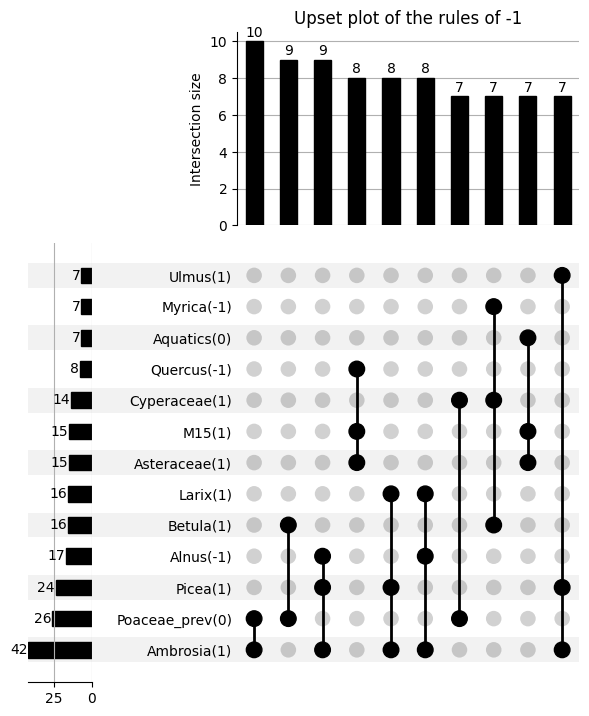

1


C:\Users\Tony\AppData\Local\Temp\ipykernel_6488\751918124.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["confidence"] = df["true_positives"] * df["accuracy"]


,head_variable,head_value,body,rule_size,true_positives,false_positives,accuracy,features,confidence
191,Poaceae,1,"Ambrosia(-1), Picea(1), Ulmus(1)",3,8,0,1.0,"[Ambrosia(-1), Picea(1), Ulmus(1)]",8.0
543,Poaceae,1,"Artemesia(-1), Fraxinus(1), M15(1)",3,7,0,1.0,"[Artemesia(-1), Fraxinus(1), M15(1)]",7.0
74,Poaceae,1,"Juniperus(-1), Ulmus(1)",2,7,0,1.0,"[Juniperus(-1), Ulmus(1)]",7.0
101,Poaceae,1,"Alnus(1), Cyperaceae(-1), Picea(1)",3,6,0,1.0,"[Alnus(1), Cyperaceae(-1), Picea(1)]",6.0
574,Poaceae,1,"Betula(1), Poaceae_prev(2), Ulmus(1)",3,6,0,1.0,"[Betula(1), Poaceae_prev(2), Ulmus(1)]",6.0
729,Poaceae,1,"Ambrosia(-1), Betula(-1), Juniperus(0)",3,6,0,1.0,"[Ambrosia(-1), Betula(-1), Juniperus(0)]",6.0
865,Poaceae,1,"Ambrosia(-1), Fraxinus(1), M15(1)",3,6,0,1.0,"[Ambrosia(-1), Fraxinus(1), M15(1)]",6.0
874,Poaceae,1,"Alnus(1), Betula(-1), Poaceae_prev(1), Populus(1)",4,6,0,1.0,"[Alnus(1), Betula(-1), Poaceae_prev(1), Populu...",6.0
878,Poaceae,1,"Artemesia(-1), Pinus(1), Poaceae_prev(1), Popu...",4,6,0,1.0,"[Artemesia(-1), Pinus(1), Poaceae_prev(1), Pop...",6.0
541,Poaceae,1,"Chenopodiaceae(-1), Fraxinus(1), M15(1)",3,6,0,1.0,"[Chenopodiaceae(-1), Fraxinus(1), M15(1)]",6.0


['Alnus(1)', 'Ambrosia(-1)', 'Artemesia(-1)', 'Betula(-1)', 'Betula(1)', 'Chenopodiaceae(-1)', 'Cyperaceae(-1)', 'Fraxinus(1)', 'Juniperus(-1)', 'Juniperus(0)', 'M15(1)', 'Picea(1)', 'Pinus(1)', 'Poaceae_prev(1)', 'Poaceae_prev(2)', 'Populus(1)', 'Ulmus(1)']
17


true_pos  \
Alnus(1) Ambrosia(-1) Artemesia(-1) Betula(-1) Betula(1) Chenopodiaceae(-1) Cyperaceae(-1) Fraxinus(1) Juniperus(-1) Juniperus(0) M15(1) Picea(1) Pinus(1) Poaceae_prev(1) Poaceae_prev(2) Populus(1) Ulmus(1)             
False    False        False         False      False     False              False          False       True          False        False  False    False    False           False           False      True             7   
                                                         True               False          True        False         False        True   False    False    False           False           False      False            6   
                                               True      False              False          False       False         False        False  False    False    False           True            False      True             6   
                      True          False      False     False              False          False       False         False        False  False    True     True            False           True       False            6   
                                                                                           True        False         False        True   False    False    False           False           False      False            7   
         True         False         False      False     False              False          False       False         False        False  True     False    False           False           False      True             8   
                                                                                           True        False         False        True   False    False    False           False           False      False            6   
                                    True       False     False              False          False       False         True         False  False    False    False           False           False      False            6   
True     False        False         False      False     False              True           False       False         False        False  True     False    False           False           False      False            6   
                                    True       False     False              False          False       False         False        False  False    False    True            False           True       False            6   

                                                                                                                                                                                                                false_pos  \
Alnus(1) Ambrosia(-1) Artemesia(-1) Betula(-1) Betula(1) Chenopodiaceae(-1) Cyperaceae(-1) Fraxinus(1) Juniperus(-1) Juniperus(0) M15(1) Picea(1) Pinus(1) Poaceae_prev(1) Poaceae_prev(2) Populus(1) Ulmus(1)              
False    False        False         False      False     False              False          False       True          False        False  False    False    False           False           False      True              0   
                                                         True               False          True        False         False        True   False    False    False           False           False      False             0   
                                               True      False              False          False       False         False        False  False    False    False           True            False      True              0   
                      True          False      False     False              False          False       False         False        False  False    True     True            False           True       False             0   
                                                                                           True        False         False        True   False    False    False           False           False      False             0   
         True       

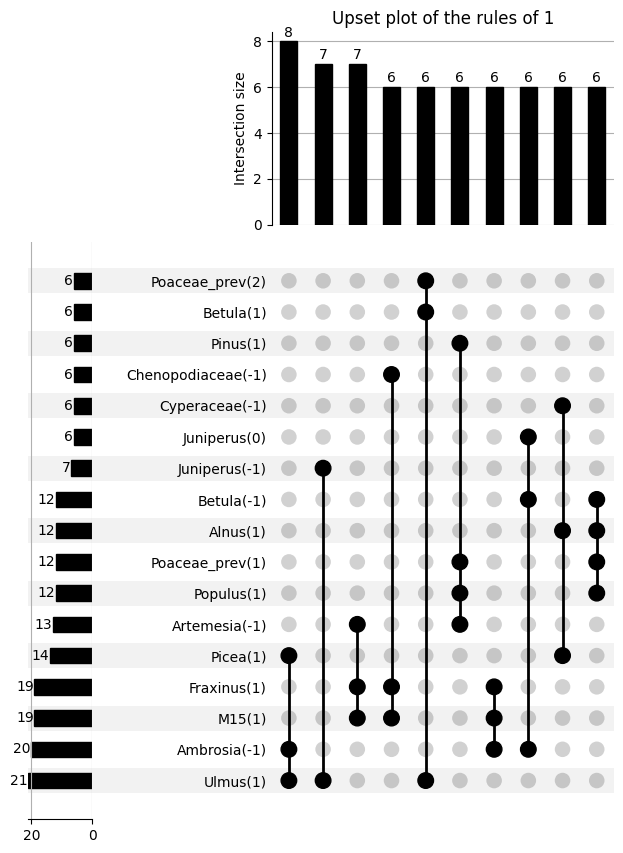

In [14]:
df_raw = df_output.copy()

df_raw["features"] = df_raw["body"].apply(lambda x: decode(x))

for head in df_raw["head_value"].unique():
    print(head)
    df = df_raw[(df_raw["head_value"] == head) & (df_raw["true_positives"] >= MIN_SUPPORT)]
    df["confidence"] = df["true_positives"] * df["accuracy"]
    df = df.sort_values("confidence", ascending=False).head(TOP_K_RULES)
    #df = df.sort_values("true_positives", ascending=False).head(TOP_K_RULES)

    display(df)

    features = set()
    for idx, row in df.iterrows():
        for i in row["features"]:
            features.add(i)

    features = list(features)
    features.sort()

    print(features)
    print(len(features))

    df_features = pd.DataFrame(columns=features)

    for idx, row in df.iterrows():
        data = {key:[False] for key in features}
        for condition in row["features"]:
            data[condition] = [True]
        df_features = pd.concat([df_features, pd.DataFrame(data)], axis=0).astype({key:bool for key in features})

    df_features["true_pos"] = df["true_positives"].values
    df_features["false_pos"] = df["false_positives"].values
    df_features["accuracy"] = df["accuracy"].values * 100
    df_features["confidence"] = df["confidence"].values
    df = df_features.reset_index(drop=True)

    # Clean useless column
    for col in features:
        if (not True in list(df[col].unique())):
            df = df.drop([col], axis=1)

    #display(df)

    conditions = [c for c in list(df.columns) if c not in ["true_pos","false_pos","accuracy","confidence"]]
    df = df.groupby(conditions).sum(numeric_only=True)
    display(df)

    upset = UpSet(df, show_counts=True, sort_by="cardinality", sum_over='confidence', subset_size="sum")
    #upset.add_catplot(kind="bar",value="false_pos")
    #upset.add_catplot(kind="bar",value="true_pos", color="blue")
    #upset.add_catplot(kind="bar",value="false_pos", color="red")
    #upset.add_catplot(kind="bar",value="accuracy", color="gray")
    upset.plot()
    plt.title("Upset plot of the rules of "+str(head), loc="center")
    plt.savefig("tmp/upset_plot_lfit_"+str(head)+"_top_"+str(TOP_K_RULES)+"_lvl_"+str(LEVELS)+".pdf",bbox_inches='tight')
    plt.show()


# Vendiagram

# TODO